# Notebook 01: Ports and Waves – Fundamentals of Wave Digital Filters

This notebook introduces the foundational concepts of Wave Digital Filters (WDFs), combining classical circuit theory, signal modeling, and power-based reasoning.

We will:

- Define electrical ports and Kirchhoff variables $(v, i)$  
- Derive **wave variables** $(a, b)$ from physical quantities  
- Explain **power and passivity** in the wave domain  
- Discuss **realizability and delay-free loops**  
- Introduce the **parametric wave definition** for generality  
- Align all theory with the implementation style of `pywdf`  

This is the **core theoretical base** of our WDF framework.


## 1. Electrical Ports and Kirchhoff Variables

An **electrical port** is a conceptual interface between a physical system and its environment, defined by **two time-dependent variables**:

- **Voltage** $ v(t) $: the electric potential difference between the two terminals of the port.
- **Current** $ i(t) $: the electric current entering the system through the port.

These quantities are called **Kirchhoff variables**, as they are governed by the two fundamental circuit laws introduced by Gustav Kirchhoff:

---

### Kirchhoff's Laws

– KCL: at any junction, the algebraic sum of currents entering equals zero.

– KVL: in any closed loop, the algebraic sum of voltages is zero.

1. **Kirchhoff’s Current Law (KCL)**  
   The total current flowing into any node equals the total current flowing out:  
   $$
   \sum_{\text{nodes}} i(t) = 0
   $$
   This expresses **conservation of charge**.

2. **Kirchhoff’s Voltage Law (KVL)**  
   The algebraic sum of voltages in any closed loop is zero:  
   $$
   \sum_{\text{loop}} v(t) = 0
   $$
   This expresses **conservation of energy** in electrical circuits.


---

### Voltage and Current as Generalized Variables

The pair $ (v, i) $ completely characterizes the power exchange at a port:

- **Instantaneous power** entering the system is:
  $$
  P(t) = v(t) \cdot i(t)
  $$

This formulation is **model-independent** and applies to any linear or nonlinear component.  
It also allows generalization to **multi-domain systems** (e.g., mechanical, acoustic), where analogous port variables (force/velocity, pressure/flow) are used.

---

### Example: Ohm’s Law

A resistor imposes a linear relationship between voltage and current:

$$
v(t) = R \cdot i(t)
$$

- $ R $ is the resistance (in ohms, $ \Omega $).
- The resistor is **passive**: it always dissipates energy as heat.
- It has no memory (stateless), and is **instantaneously causal**.

This is the foundation for modeling **algebraic one-port** elements.

In wave‐domain terms (to come), an Ohmic one-port will simply reflect zero wave (i.e.\ $b=0$) when port resistance $R_0$ is matched to $R$.

---



## 2. From Kirchhoff Variables to Wave Variables

In Wave Digital Filters (WDFs), we move from the standard voltage/current domain to **wave variables**, which are better suited for real-time signal processing and modeling energy flow.

Let:

- $ v $: port voltage
- $ i $: port current
- $ R_0 $: port resistance (a free design parameter)
- $ a $: **incident wave**
- $ b $: **reflected wave**

The wave variables are defined as:

$$
\boxed{
a = v + R_0 i, \quad b = v - R_0 i
}
$$

This is exactly the “voltage wave” convention ($\rho=1$). It might help to briefly remind: > Because we chose $\rho=1$, these waves have units of volts. Later, we’ll see how to generalize to current‐waves and power‐normalized waves.

---

###  Inverse transformation

Solving for $v$ and $i$:

$$
\begin{aligned}
a + b &= (v + R_0 i) + (v - R_0 i) = 2v \\
&\Rightarrow v = \frac{a + b}{2} \\\\
a - b &= (v + R_0 i) - (v - R_0 i) = 2 R_0 i \\
&\Rightarrow i = \frac{a - b}{2 R_0}
\end{aligned}
$$

So the inverse equations are:

$$
\boxed{
v = \frac{a + b}{2}, \quad i = \frac{a - b}{2 R_0}
}
$$

This transformation is **linear and invertible** as long as $ R_0 \ne 0 $.


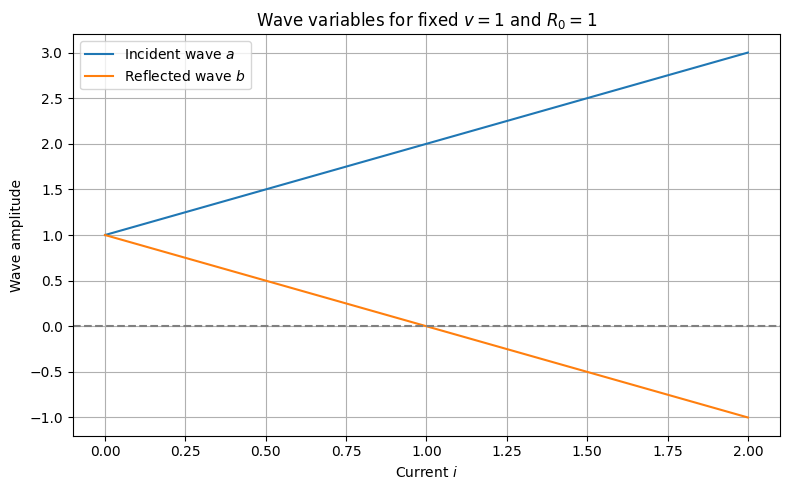

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def vi_to_ab(v, i, R0):
    a = v + R0 * i
    b = v - R0 * i
    return a, b


i_vals = np.linspace(0, 2, 200)
v = 1.0
R0 = 1.0

a_vals, b_vals = zip(*[vi_to_ab(v, i, R0) for i in i_vals])

plt.figure(figsize=(8, 5))
plt.plot(i_vals, a_vals, label='Incident wave $a$')
plt.plot(i_vals, b_vals, label='Reflected wave $b$')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Current $i$")
plt.ylabel("Wave amplitude")
plt.title("Wave variables for fixed $v=1$ and $R_0 = 1$")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Because $v$ is fixed at 1 V, as current increases, $a$ and $b$ move linearly apart. Notice that at $i=0$, $a=b=1$ (purely standing wave).

## 3. Power and Passivity in Wave Terms

The **instantaneous power** delivered to a port is:

$$
P = v \cdot i
$$

Substituting wave variables:

$$
P = (a + b) \cdot \frac{a - b}{R_0} = \frac{a^2 - b^2}{R_0}
$$

So we get:

$$
\boxed{P \propto a^2 - b^2}
$$

This means:

- If $a^2 > b^2$ → the component **absorbs power** → passive
- If $a^2 < b^2$ → the component **generates power** → active

This energy-based formulation is key to ensuring **stability** in WDF systems.


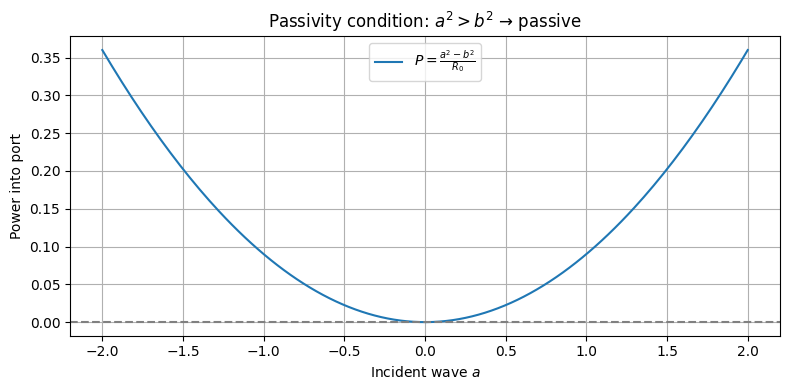

In [2]:
a = np.linspace(-2, 2, 200)
b = 0.8 * a  # reflected wave is smaller (passive case)

power = 0.25 * (a**2 - b**2) / R0

plt.figure(figsize=(8, 4))
plt.plot(a, power, label=r'$P = \frac{a^2 - b^2}{R_0}$')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Incident wave $a$")
plt.ylabel("Power into port")
plt.title("Passivity condition: $a^2 > b^2$ → passive")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## 4. Realizability and Delay-Free Loops

In digital systems, we must ensure **causality**: each output sample is computed from present or past inputs.

A **delay-free loop** occurs when two components depend algebraically on each other’s outputs — this is **non-causal**.

---

### Solution in WDF:
- Organize components into a **connection tree**
- Insert **delays** into reactive elements
- Compute in **two passes**:
  - Reflected wave $b$: from leaves to root
  - Incident wave $a$: from root to leaves

This guarantees **real-time computability** and **numerical stability**.


## 5. Parametric Wave Definitions (Werner, 2016)

Although WDFs are based on *waves*, these waves are derived from traditional physical variables:

| Domain     | Variable         | Typical Use                     |
|------------|------------------|---------------------------------|
| Voltage    | $v(t)$           | Analog modeling, passive ports  |
| Current    | $i(t)$           | Source modeling, feedback ports |
| Power      | $p(t) = v(t)i(t)$ | Energy flow, passivity check    |
| Waves      | $a(t), b(t)$     | Simulation variables in WDF     |

In WDFs, we **encode the behavior** of analog components using $(a, b)$ — which are **derived** from either voltage/current or power variables.

The wave domain is used for **numerical computation**, but still retains the physical meaning.

To unify different types of wave modeling, we define:

$$
a = R_0^{\rho - 1} v + R_0^\rho i \\
b = R_0^{\rho - 1} v - R_0^\rho i
$$

Where $\rho$ determines the wave type:

| $\rho$ | Wave Type        | $a$ Expression                      |
|--------|------------------|-------------------------------------|
| $1$    | Voltage wave     | $a = v + R_0 i$                     |
| $1/2$  | Power-normalized | $a = \sqrt{R_0} v + R_0 i$          |
| $0$    | Current wave     | $a = \frac{v}{R_0} + i$             |

This formulation allows WDFs to be extended to **mechanical, acoustic, or hybrid systems**.


## 6. Simulating Wave Variables Over Time

So far, we’ve defined wave variables $(a, b)$ and shown how they relate to voltage, current, and power at a single time instant.

But WDFs are **dynamic systems**, designed to process **signals** over time — especially in audio and control applications.

Let’s simulate what happens when a time-varying **sine wave voltage** is applied to a simple **resistor** modeled as a WDF one-port.

---

###  Setup

- **Input**: a sine wave $v[n] = \sin(2\pi f n / f_s)$
- **Component**: a resistor $R$
- **Port resistance**: $R_0 = R$ (impedance matched)
- **Time**: 5 ms at 44.1 kHz

---

###  Behavior

- The resistor has **no internal state** and reflects no wave: $b[n] = 0$
- Therefore:
  - $a[n] = v[n]$
  - $i[n] = \dfrac{v[n]}{R}$
- The **instantaneous power** is:
  $$
  P[n] = \frac{a[n]^2 - b[n]^2}{R_0} = \frac{v[n]^2}{R}
  $$

This is a great way to **observe how power is dissipated** by a passive element over time.

Let’s simulate and visualize this using Python.


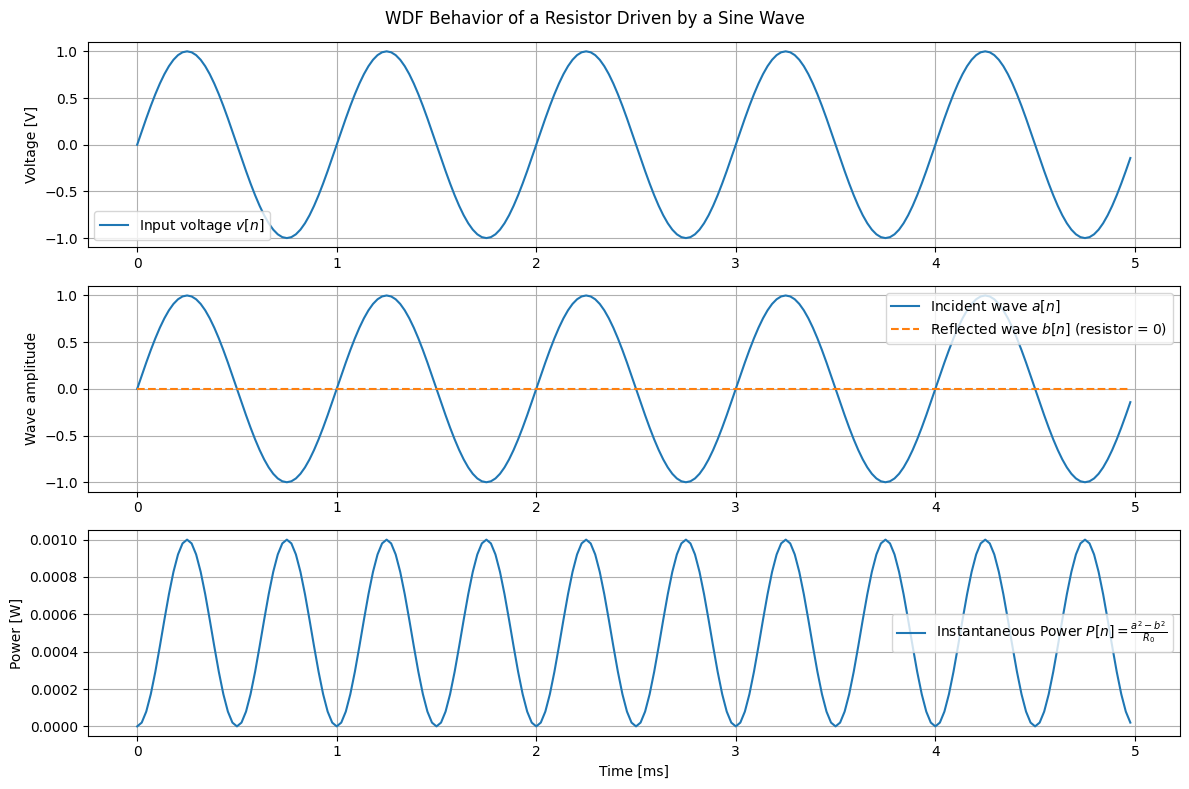

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
R0 = 1000  # Port resistance in Ohms
f = 1000   # Frequency of sine wave (Hz)
fs = 44100 # Sample rate (Hz)
duration = 0.005  # 5 milliseconds
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Input voltage: sine wave
v_in = np.sin(2 * np.pi * f * t)

# Simulate resistor behavior
# Resistor: reflected wave is always 0
b = np.zeros_like(v_in)

# Compute wave variables from input voltage
a = v_in  # Because b = 0 → a = v (since v = a + b)
v = a + b  # Should equal v_in
i = (a - b) / R0  # Ohm’s law: i = v / R

# Compute instantaneous power
power = (a**2 - b**2) / R0

# Plot everything
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t * 1000, v_in, label='Input voltage $v[n]$')
plt.ylabel("Voltage [V]")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t * 1000, a, label='Incident wave $a[n]$')
plt.plot(t * 1000, b, '--', label='Reflected wave $b[n]$ (resistor = 0)')
plt.ylabel("Wave amplitude")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t * 1000, power, label=r'Instantaneous Power $P[n] = \frac{a^2 - b^2}{R_0}$')
plt.xlabel("Time [ms]")
plt.ylabel("Power [W]")
plt.grid(True)
plt.legend()

plt.suptitle("WDF Behavior of a Resistor Driven by a Sine Wave")
plt.tight_layout()
plt.show()
